In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
from natsort import natsorted
import xarray as xr

import matplotlib.pyplot as plt
import sunpy.visualization.colormaps as cm
from codecarbon import track_emissions

In [2]:
data_path = "../../data/all128.nc"
ds = xr.open_dataset(data_path)

In [3]:
def denormalize(data, mean, std):
    return data * std + mean

def load_mean_std(file_path):
    with open(file_path, "rb") as f:
        stats = pickle.load(f)
        mean = stats["mean"]
        std = stats["std"]
    return mean, std

In [4]:
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (B, 32, 128, 128)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B, 64, 128, 128)
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # (B, 32, 128, 128)
            nn.ReLU(),
            nn.Conv2d(32, 8, kernel_size=3, padding=1)    # (B, 8, 128, 128)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=8):
        super(CNN, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)  # 128 -> 64

        self.enc2 = self.conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)  # 64 -> 32

        # Bottleneck
        self.bottleneck = self.conv_block(64, 128)

        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 32 -> 64
        self.dec1 = self.conv_block(128, 64)

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 64 -> 128
        self.dec2 = self.conv_block(64, 32)

        # Output
        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)  # (B, 32, 128, 128)
        p1 = self.pool1(e1)  # (B, 32, 64, 64)

        e2 = self.enc2(p1)  # (B, 64, 64, 64)
        p2 = self.pool2(e2)  # (B, 64, 32, 32)

        # Bottleneck
        b = self.bottleneck(p2)  # (B, 128, 32, 32)

        # Decoder
        u1 = self.up1(b)  # (B, 64, 64, 64)
        d1 = self.dec1(torch.cat([u1, e2], dim=1))  # Skip conn.

        u2 = self.up2(d1)  # (B, 32, 128, 128)
        d2 = self.dec2(torch.cat([u2, e1], dim=1))  # Skip conn.

        out = self.out_conv(d2)  # (B, 8, 128, 128)
        return out


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Encoder-Teil
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (B, 32, 128, 128)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B, 64, 128, 128)
            nn.ReLU(),
            nn.Conv2d(
                64, 128, kernel_size=3, padding=1
            ),  # (B, 128, 128, 128) (zusätzlicher Layer)
            nn.ReLU(),
        )

        # Decoder-Teil
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # (B, 64, 128, 128)
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # (B, 32, 128, 128)
            nn.ReLU(),
            nn.Conv2d(32, 8, kernel_size=3, padding=1),  # (B, 8, 128, 128)
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
class LiteUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=8):
        super(LiteUNet, self).__init__()

        # Encoder (weniger Filter)
        self.enc1 = self.conv_block(in_channels, 16)
        self.enc2 = self.conv_block(16, 32)

        # Bottleneck
        self.bottleneck = self.conv_block(32, 64)

        # Decoder
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(64, 32)

        self.up2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(32, 16)

        self.out_conv = nn.Conv2d(16, out_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(2)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)              # -> (B, 16, 128, 128)
        e2 = self.enc2(self.pool(e1))  # -> (B, 32, 64, 64)

        # Bottleneck
        b = self.bottleneck(self.pool(e2))  # -> (B, 64, 32, 32)

        # Decoder
        d1 = self.up1(b)                     # -> (B, 32, 64, 64)
        d1 = self.dec1(torch.cat([d1, e2], dim=1))

        d2 = self.up2(d1)                    # -> (B, 16, 128, 128)
        d2 = self.dec2(torch.cat([d2, e1], dim=1))

        out = self.out_conv(d2)              # -> (B, 8, 128, 128)
        return out

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity  # Residual connection
        return self.relu(out)

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        self.input_conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # (B, 64, 128, 128)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.resblock1 = ResidualBlock(64)
        self.resblock2 = ResidualBlock(64)
        self.resblock3 = ResidualBlock(64)

        self.output_conv = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # (B, 32, 128, 128)
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 8, kernel_size=3, padding=1),   # (B, 8, 128, 128)
        )

    def forward(self, x):
        x = self.input_conv(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.output_conv(x)
        return x

In [9]:
# Dataset-class
class ChannelPredictionDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs.unsqueeze(1)  # shape: (N, 1, 128, 128)
        self.targets = targets             # shape: (N, 8, 128, 128)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

In [10]:
base_path = "./models/origin_mse/"

#path_input_mean_std = base_path + "inputs_mean_std.pkl"
#path_target_mean_std = base_path + "targets_mean_std.pkl"
path_model = base_path + "model.pth"

#inputs_mean, inputs_std = load_mean_std(path_input_mean_std)
#targets_mean, targets_std = load_mean_std(path_target_mean_std)

model = CNN_2()  # check same arch
model.load_state_dict(torch.load(path_model))
model.eval()

CNN_2(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [11]:
def stack_channels(ds):
    channels = ['131A', '1600A', '1700A', '171A', '193A', '211A', '304A', '335A', '94A']
    data_list = []
    for ch in channels:
        da = ds.sel(channel=ch)['DN']  # shape: (time, x, y)
        data_list.append(da.values)    # (time, x, y)
    data_array = np.stack(data_list, axis=1)  # shape: (time, channel, x, y)
    return data_array

full_data = stack_channels(ds)  # shape: (6130, 9, 128, 128)

# Input: Channel 94A (index 8)
# Output:  Channels (indices 0–7)
inputs = full_data[:, 8, :, :]         # shape: (6130, 128, 128)
targets = full_data[:, 0:8, :, :]      # shape: (6130, 8, 128, 128)

# convert to torch
inputs_tensor = torch.from_numpy(inputs).float()
targets_tensor = torch.from_numpy(targets).float()

# create dataset
full_dataset = ChannelPredictionDataset(inputs_tensor, targets_tensor)

# Training/Test split (80% / 20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

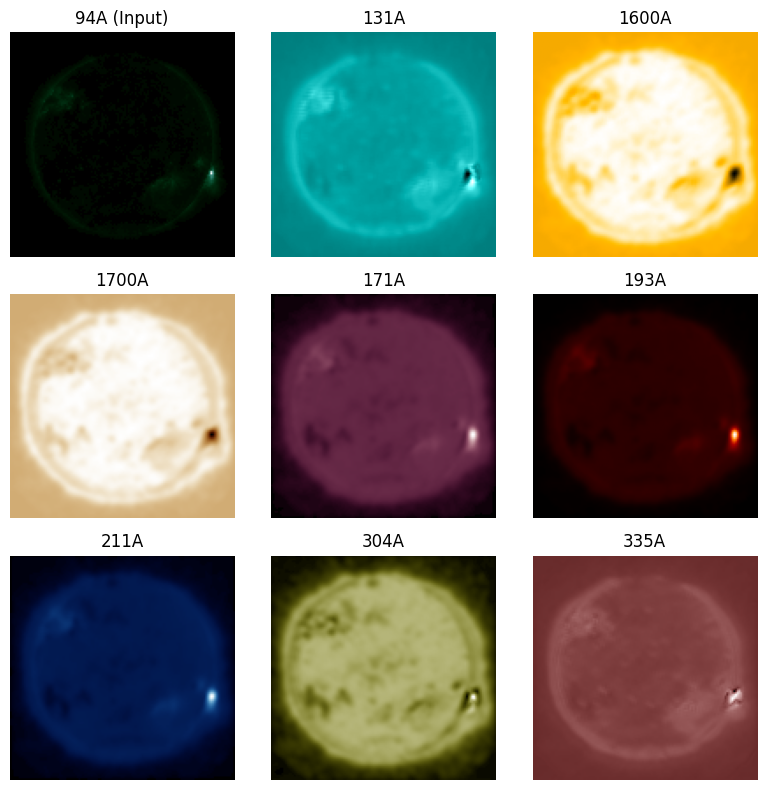

In [12]:
input_img, target_img = test_dataset[0]  # input: (1, 128, 128), target: (8, 128, 128)
#input_img = denormalize(input_img, inputs_mean, inputs_std)
#target_img = denormalize(target_img, targets_mean, targets_std)
input_img = input_img.unsqueeze(0)  # (1, 1, 128, 128)

with torch.no_grad():
    predicted = model(input_img).squeeze(0)  # (8, 128, 128)

input_np = input_img.squeeze(0).squeeze(0).numpy()  # (128, 128)
pred_np = predicted.numpy()  # (8, 128, 128)
target_np = target_img.numpy()

keys = natsorted(ds['channel'].data)
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
channels = ['94A (Input)', '131A', '1600A', '1700A', '171A', '193A', '211A', '304A', '335A']

for i, (ax, ch, key) in enumerate(zip(axes.ravel(), channels, keys)):
    cmap = plt.get_cmap(f'sdoaia{key[:-1]}')
    if ch == '94A (Input)':
        ax.imshow(input_np, cmap=cmap)
    else:
        ax.imshow(pred_np[i-1], cmap=cmap)
    
    ax.set_title(ch)
    ax.axis('off')

plt.tight_layout()
plt.savefig(base_path + "abc.png")
plt.show()

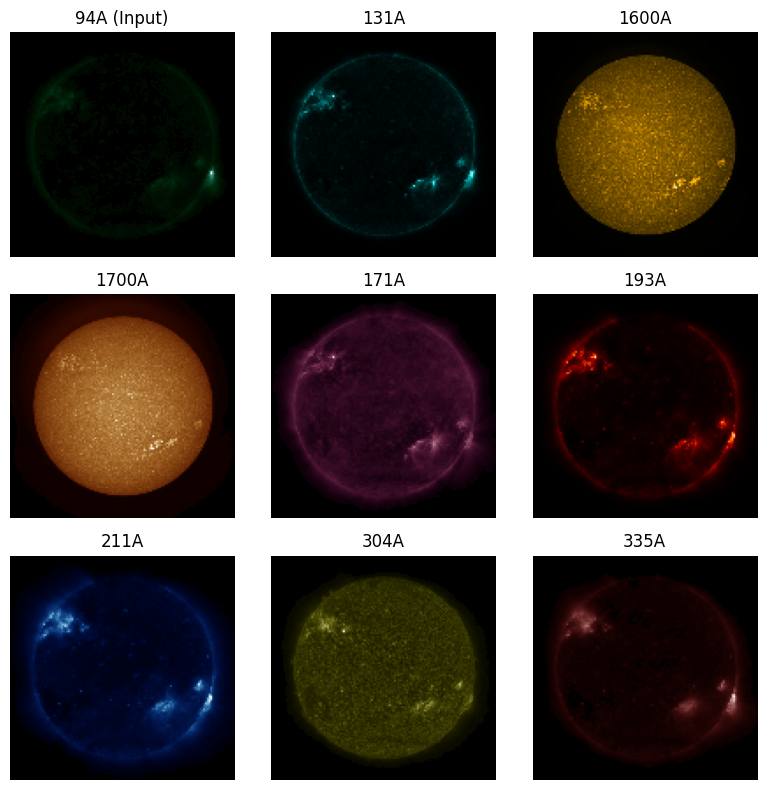

In [13]:
fig_2, axes_2 = plt.subplots(3, 3, figsize=(8, 8))
for i, (ax, ch, key) in enumerate(zip(axes_2.ravel(), channels, keys)):
    cmap = plt.get_cmap(f'sdoaia{key[:-1]}')
    if ch == '94A (Input)':
        ax.imshow(input_np, cmap=cmap)
    else:
        ax.imshow(target_np[i-1], cmap=cmap)
    
    ax.set_title(ch)
    ax.axis('off')

plt.tight_layout()
plt.show()